In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from epitools import between_p, within_p
import matplotlib.ticker as mtick


In [2]:
candidates = list("abcdefghijklmnopqrstuvw")[0:4]

output = []
polling_id = 1
for loop in range(1):
    for candidate_a in candidates:
        for candidate_b in candidates:
            rate = 0 if candidate_a != candidate_b else 1
            rate = 1/len(candidates)
            output.append({
                "candidate": candidate_b,
                "rate": rate,
                "polling_id": polling_id
            })
        polling_id += 1

df = pd.DataFrame(output)
df["value"] = df["rate"] * 100
df.head()

,candidate,rate,polling_id,value
0,a,0.25,1,25.0
1,b,0.25,1,25.0
2,c,0.25,1,25.0
3,d,0.25,1,25.0
4,a,0.25,2,25.0


### Election with 2 candidates, 3 districts

In [3]:
def generate_data(rates, candidate_label="A"):
    if candidate_label == "A":
        data = pd.DataFrame(np.array(rates))
    else:
        data = pd.DataFrame(1 - np.array(rates))

    data["election_id"] = range(1, data.shape[0] + 1)
    data = data.melt(id_vars=["election_id"], var_name="polling_id", value_name="rate")
    data["candidate"] = candidate_label
    
    return data

In [4]:
def get_election_data(
    N_candidates = 2,
    N_elections = 5000,
    N_units = 3
):
    data = np.random.dirichlet(np.ones(N_candidates), size=(N_elections, N_units))

    df_election = []
    for idx, election in enumerate(data):

        tmp = pd.DataFrame(election)
        tmp["election_id"] = f"{(idx + 1)}-{N_candidates}"
        tmp["polling_id"] = range(1, tmp.shape[0] + 1)
        tmp = tmp.melt(id_vars=["election_id", "polling_id"], value_name="rate", var_name="candidate")
        tmp["value"] = (100 * tmp["rate"]).astype(int)
        
        df_election.append(tmp)

    df_election = pd.concat(df_election, ignore_index=True)
    df_election["polling_id"] = df_election["polling_id"].astype(int)
    df_election["candidate"] = df_election["candidate"].astype(str)
    df_election["N_candidates"] = N_candidates
    
    return df_election

In [5]:
N_elections = 250

output = []

for N_units in [2, 3, 5, 100, 1000, 5000]:
    df_election = get_election_data(
        N_candidates = 2,
        N_elections = N_elections,
        N_units = N_units
    )

    for i in range(3, 6 + 1):
        tmp = get_election_data(
            N_candidates = i,
            N_elections = N_elections,
            N_units = N_units
        )
        df_election = pd.concat([df_election, tmp])

    df_election["N_units"] = N_units
    output.append(df_election)

df_election = pd.concat(output, ignore_index=True)
df_election.head()

,election_id,polling_id,candidate,rate,value,N_candidates,N_units
0,1-2,1,0,0.235963,23,2,2
1,1-2,2,0,0.928472,92,2,2
2,1-2,1,1,0.764037,76,2,2
3,1-2,2,1,0.071528,7,2,2
4,2-2,1,0,0.154018,15,2,2


In [6]:
df_election = pd.concat(output, ignore_index=True)
df_election.head()

,election_id,polling_id,candidate,rate,value,N_candidates,N_units
0,1-2,1,0,0.235963,23,2,2
1,1-2,2,0,0.928472,92,2,2
2,1-2,1,1,0.764037,76,2,2
3,1-2,2,1,0.071528,7,2,2
4,2-2,1,0,0.154018,15,2,2


In [7]:
df_election.shape

(30550000, 7)

In [8]:
output = []
for idx, tmp in df_election.groupby(["election_id", "N_candidates", "N_units"]):
    election_id, N_candidates, N_units = idx
    value_a = between_p(tmp)
    value_b = within_p(tmp)
    df_dv = pd.concat([value_a, value_b])
    df_dv["election_id"] = election_id
    df_dv["N_candidates"] = N_candidates
    df_dv["N_units"] = N_units
    output.append(df_dv)

data = pd.concat(output, ignore_index=True)
data.head()

,candidate,value,weight,type,election_id,N_candidates,N_units
0,0,0.104415,0.580808,Between,1-2,2,2
1,1,0.222095,0.419192,Between,1-2,2,2
2,0,0.347100,0.580808,Within,1-2,2,2
3,1,0.345083,0.419192,Within,1-2,2,2
4,0,0.248495,0.494949,Between,1-2,2,3


In [9]:
data.to_csv("simulation_epi.csv", index=False)

In [10]:
data = pd.read_csv("simulation_epi.csv")
data.head()

,candidate,value,weight,type,election_id,N_candidates,N_units
0,0,0.104415,0.580808,Between,1-2,2,2
1,1,0.222095,0.419192,Between,1-2,2,2
2,0,0.347100,0.580808,Within,1-2,2,2
3,1,0.345083,0.419192,Within,1-2,2,2
4,0,0.248495,0.494949,Between,1-2,2,3


In [11]:
N_candidates = 3
N_units = 5
dd = df_election[(df_election["N_candidates"] == N_candidates) & (df_election["N_units"] == N_units)]\
    .groupby(["election_id", "candidate", "N_units"]).agg({"rate": "mean", "N_candidates": "mean"})#.sort_values("rate")
dd["distance"] = np.absolute(dd["rate"] - 1/dd["N_candidates"])
dd = dd.reset_index()
dd = dd.groupby("election_id").agg({"distance": "sum", "N_candidates": "mean", "N_units": "mean"}).sort_values("distance").reset_index()
dd

,election_id,distance,N_candidates,N_units
0,242-3,0.006127,3.0,5.0
1,197-3,0.016729,3.0,5.0
2,201-3,0.033639,3.0,5.0
3,171-3,0.038167,3.0,5.0
4,153-3,0.040765,3.0,5.0
...,...,...,...,...
245,63-3,0.593204,3.0,5.0
246,100-3,0.603526,3.0,5.0
247,215-3,0.615534,3.0,5.0
248,210-3,0.657675,3.0,5.0


In [12]:
yy = data.groupby(["election_id", "N_units", "N_candidates", "type"]).agg({"value": "sum"}).reset_index()
yy = yy.pivot(index=["election_id", "N_units", "N_candidates"], columns="type", values="value").reset_index()
yy["ratio"] = yy["Between"] / yy["Within"]
yy

type,election_id,N_units,N_candidates,Between,Within,ratio
0,1-2,2,2,0.326510,0.692183,0.471710
1,1-2,3,2,0.371812,0.631620,0.588664
2,1-2,5,2,0.434790,0.409016,1.063014
3,1-2,100,2,0.536824,0.464764,1.155047
4,1-2,1000,2,0.499774,0.500174,0.999201
...,...,...,...,...,...,...
7495,99-6,3,6,0.790723,0.143531,5.509071
7496,99-6,5,6,0.856939,0.098980,8.657686
7497,99-6,100,6,0.777011,0.189839,4.092997
7498,99-6,1000,6,0.787420,0.180819,4.354739


In [13]:
asd = pd.merge(yy, dd, on=["election_id", "N_units", "N_candidates"])

display(asd.sort_values("distance"))
# sns.scatterplot(y="Within", x="distance", data=asd)

,election_id,N_units,N_candidates,Between,Within,ratio,distance
159,242-3,5,3,0.598396,0.347019,1.724386,0.006127
108,197-3,5,3,0.559568,0.416161,1.344596,0.016729
114,201-3,5,3,0.702958,0.262772,2.675165,0.033639
80,171-3,5,3,0.762726,0.203790,3.742703,0.038167
60,153-3,5,3,0.712130,0.241231,2.952063,0.040765
...,...,...,...,...,...,...,...
210,63-3,5,3,0.657454,0.188799,3.482303,0.593204
2,100-3,5,3,0.592397,0.259342,2.284233,0.603526
129,215-3,5,3,0.577593,0.355688,1.623878,0.615534
124,210-3,5,3,0.613612,0.203779,3.011163,0.657675


In [14]:
df_election[(df_election["election_id"] == "74-3") & (df_election["N_units"] == 100)]

,election_id,polling_id,candidate,rate,value,N_candidates,N_units
121900,74-3,1,0,0.240685,24,3,100
121901,74-3,2,0,0.194530,19,3,100
121902,74-3,3,0,0.087959,8,3,100
121903,74-3,4,0,0.117231,11,3,100
121904,74-3,5,0,0.243519,24,3,100
...,...,...,...,...,...,...,...
122195,74-3,96,2,0.376489,37,3,100
122196,74-3,97,2,0.344458,34,3,100
122197,74-3,98,2,0.478826,47,3,100
122198,74-3,99,2,0.086673,8,3,100


In [17]:
import random

output = []
epi = {}
for idx, distribution in enumerate([
    [random.gauss(mu=0.05, sigma=0.0025) for x in range(1000)],
    [random.gauss(mu=0.05, sigma=0.025) for x in range(1000)],
    [random.gauss(mu=0.25, sigma=0.05) for x in range(1000)],
    [random.gauss(mu=0.35, sigma=0.05) for x in range(1000)],
    [random.gauss(mu=0.5, sigma=0.05) for x in range(1000)],
    [random.gauss(mu=0.5, sigma=0.25) for x in range(1000)]
]):

    df_a = pd.DataFrame(distribution, columns=["rate"])
    df_a["candidate"] = "A"
    df_a["polling_id"] = range(df_a.shape[0])
    df_a.loc[df_a["rate"] <= 0, "rate"] = 0
    df_a.loc[df_a["rate"] >= 1, "rate"] = 1

    # df_a["rate"] = df_a["rate"].apply(lambda x: np.round(x, 2))
    df_a["rate"] = df_a["rate"].apply(lambda x: x - x%0.01)

    df_b = df_a.copy()
    df_b["candidate"] = "B"
    df_b["rate"] = 1 - df_b["rate"]

    df = pd.concat([df_a, df_b], ignore_index=True)
    df["election_id"] = idx + 1
    df["value"] = df["rate"] * 100
    output.append(df)
    bw = between_p(df)["value"].sum()
    wt = within_p(df)["value"].sum()
    epi[idx + 1] = {
        "within": wt,
        "between": bw,
        "total": bw + wt
    }

df = pd.concat(output, ignore_index=True)
df.head()

,rate,candidate,polling_id,election_id,value
0,0.04,A,0,1,4.0
1,0.05,A,1,1,5.0
2,0.05,A,2,1,5.0
3,0.05,A,3,1,5.0
4,0.04,A,4,1,4.0


In [19]:
output = []
epi = {}

for idx, distribution in enumerate([
    ([random.gauss(mu=0.05, sigma=0.0025) for x in range(1000)], [random.gauss(mu=0.05, sigma=0.0025) for x in range(1000)]),
    ([random.gauss(mu=0.05, sigma=0.025) for x in range(1000)], [random.gauss(mu=0.05, sigma=0.025) for x in range(1000)]),
    ([random.gauss(mu=0.15, sigma=0.05) for x in range(1000)], [random.gauss(mu=0.25, sigma=0.05) for x in range(1000)]),
    ([random.gauss(mu=0.5, sigma=0.05) for x in range(1000)], [random.gauss(mu=0.35, sigma=0.05) for x in range(1000)]),
    ([random.gauss(mu=0.25, sigma=0.05) for x in range(1000)], [random.gauss(mu=0.25, sigma=0.05) for x in range(1000)]),
    ([random.gauss(mu=0.5, sigma=0.25) for x in range(1000)], [random.gauss(mu=0.25, sigma=0.25) for x in range(1000)])
]):
    distribution_a, distribution_b = distribution

    tmp = pd.DataFrame([
        distribution_a,
        distribution_b
    ]).T

    tmp[tmp <= 0] = 0
    tmp[tmp >= 1] = 1

    tmp.columns = ["A", "B"]
    # tmp = tmp.apply(lambda x: np.round(x, 2))
    tmp = tmp.apply(lambda x: x - x%0.01)

    tmp["B"] = tmp.apply(lambda x: 1 - x["A"] if (x["A"] + x["B"] > 1) else x["B"], axis=1)
    tmp["C"] = tmp.apply(lambda x: 1 - (x["A"] + x["B"]), axis=1)
    tmp["polling_id"] = range(tmp.shape[0])

    tmp = tmp.melt(id_vars=["polling_id"], var_name="candidate", value_name="rate")
    tmp["value"] = 100 * tmp["rate"]
    
    tmp["election_id"] = idx + 1
    output.append(tmp)

    bw = between_p(tmp)["value"].sum()
    wt = within_p(tmp)["value"].sum()
    epi[idx + 1] = {
        "within": wt,
        "between": bw,
        "total": bw + wt
    }

df = pd.concat(output, ignore_index=True)
df.head()

,polling_id,candidate,rate,value,election_id
0,0,A,0.05,5.0,1
1,1,A,0.04,4.0,1
2,2,A,0.05,5.0,1
3,3,A,0.05,5.0,1
4,4,A,0.05,5.0,1


In [43]:
df.groupby(["polling_id", "election_id"]).agg({"rate": "sum"}).sort_values("rate")

rate
polling_id election_id      
781        3             1.0
447        3             1.0
195        3             1.0
696        6             1.0
277        3             1.0
...                      ...
332        6             1.0
           5             1.0
           4             1.0
334        1             1.0
999        6             1.0

[6000 rows x 1 columns]

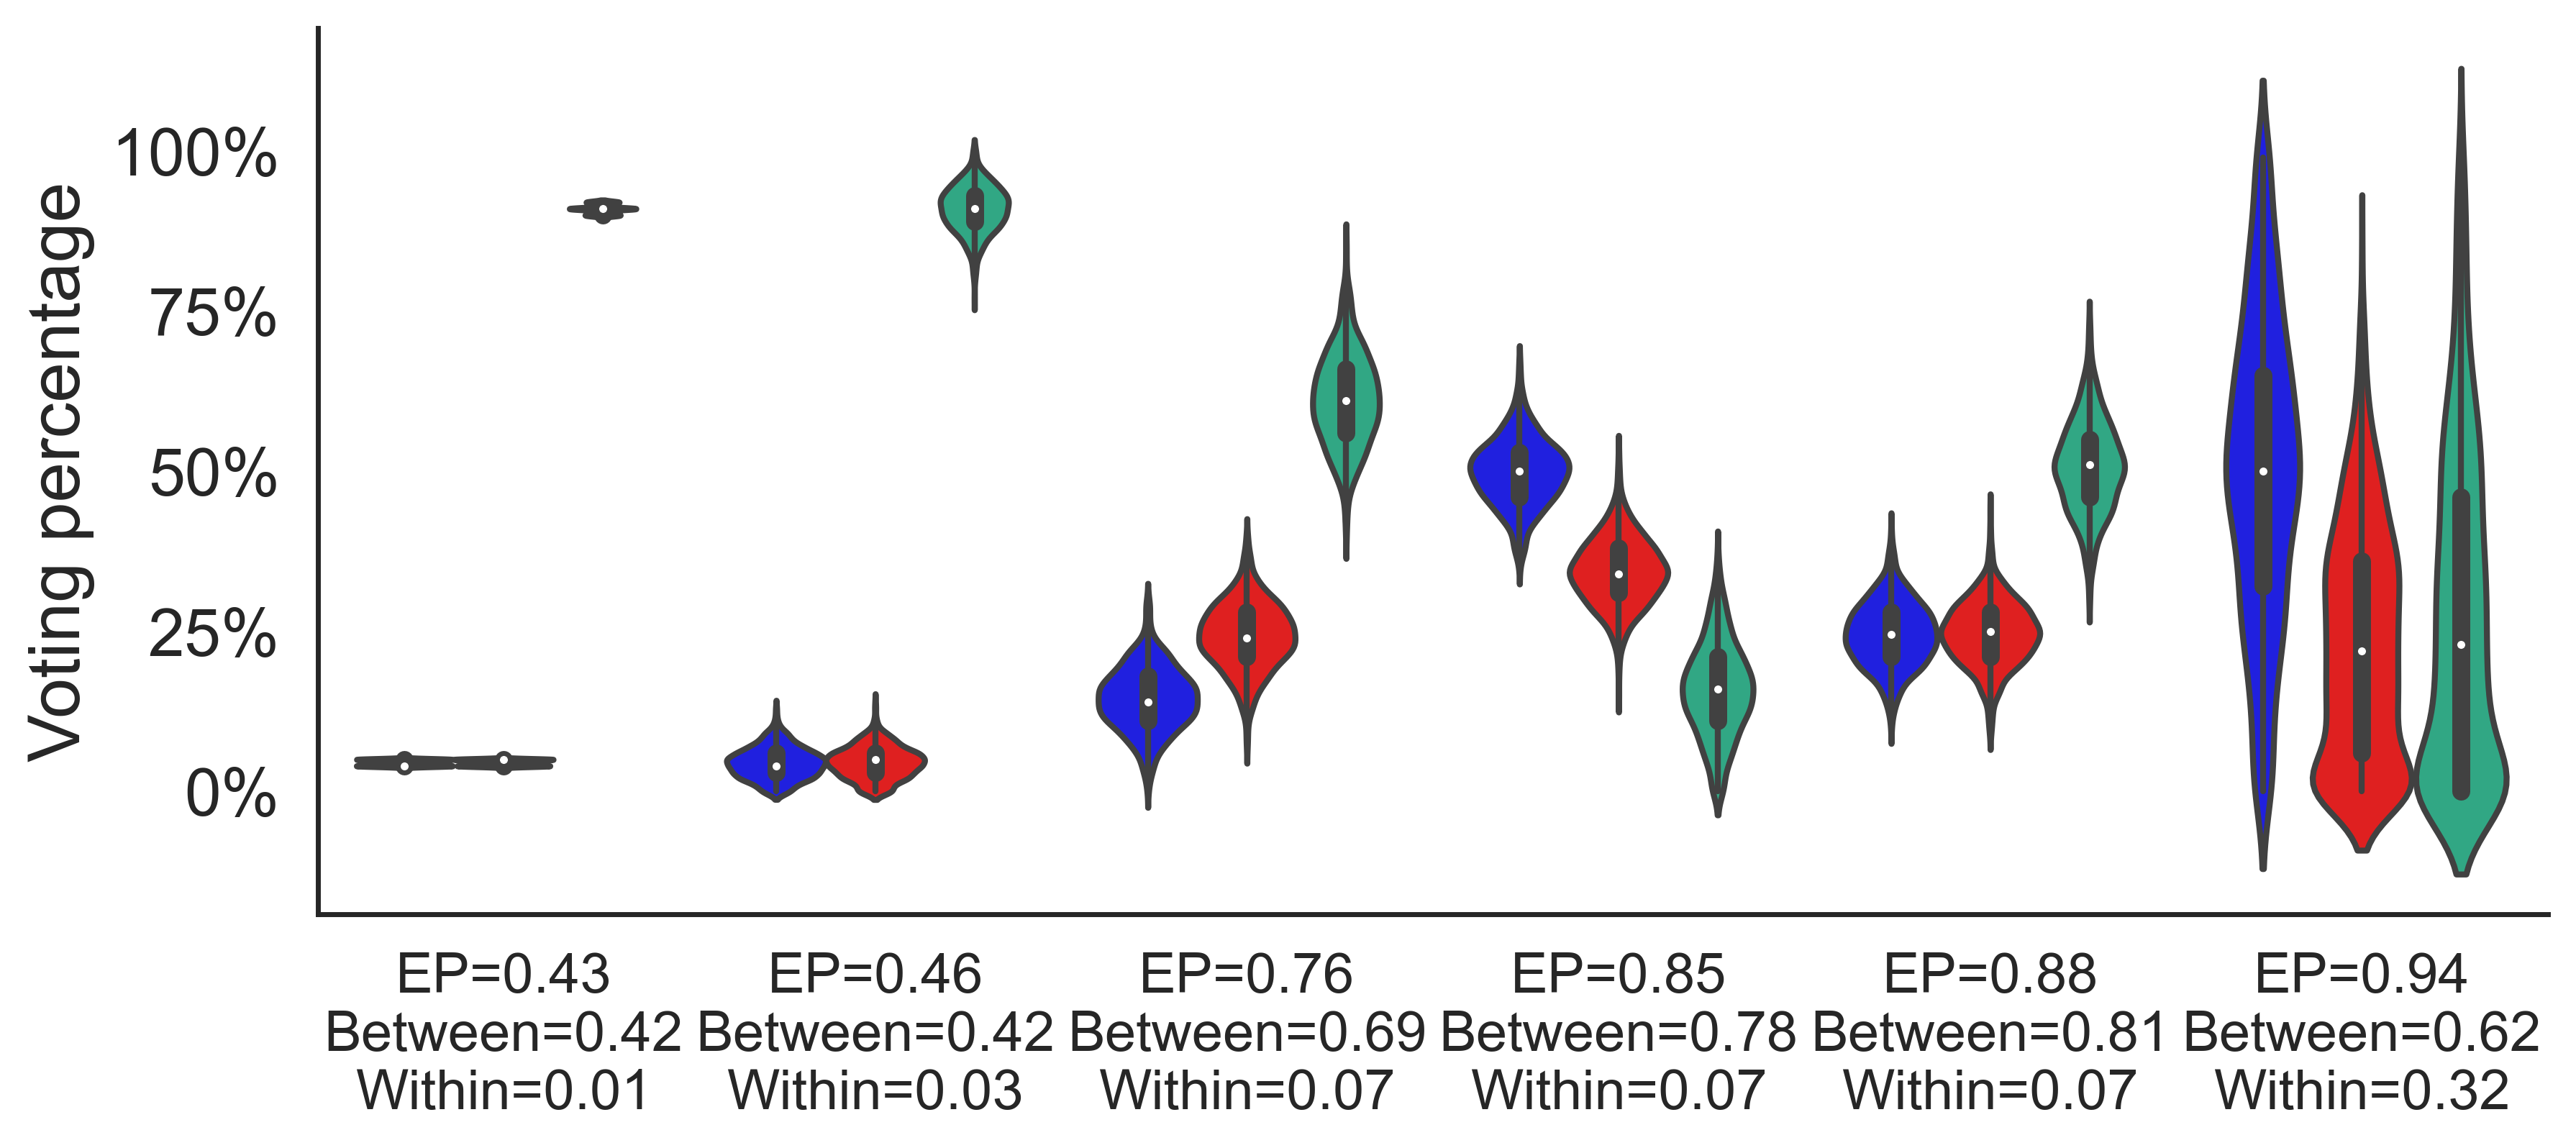

In [44]:
sns.set(font_scale=1.5, style="white")

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4), dpi=400)

sns.violinplot(y="rate", palette=["blue", "red", "#1DBB8C"], legend=False, hue="candidate", x="election_id", data=df)

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

lbls = []
for i, dd in df.groupby("election_id"):
    lbls.append(f"EP={round(epi[i]['total'], 2)}\nBetween={round(epi[i]['between'], 2)}\nWithin={round(epi[i]['within'], 2)}")

ax.set_xticklabels(lbls, fontsize=14)

leg = ax.legend()
leg.remove()
ax.set_xlabel("")
ax.set_ylabel("Voting percentage")
sns.despine()

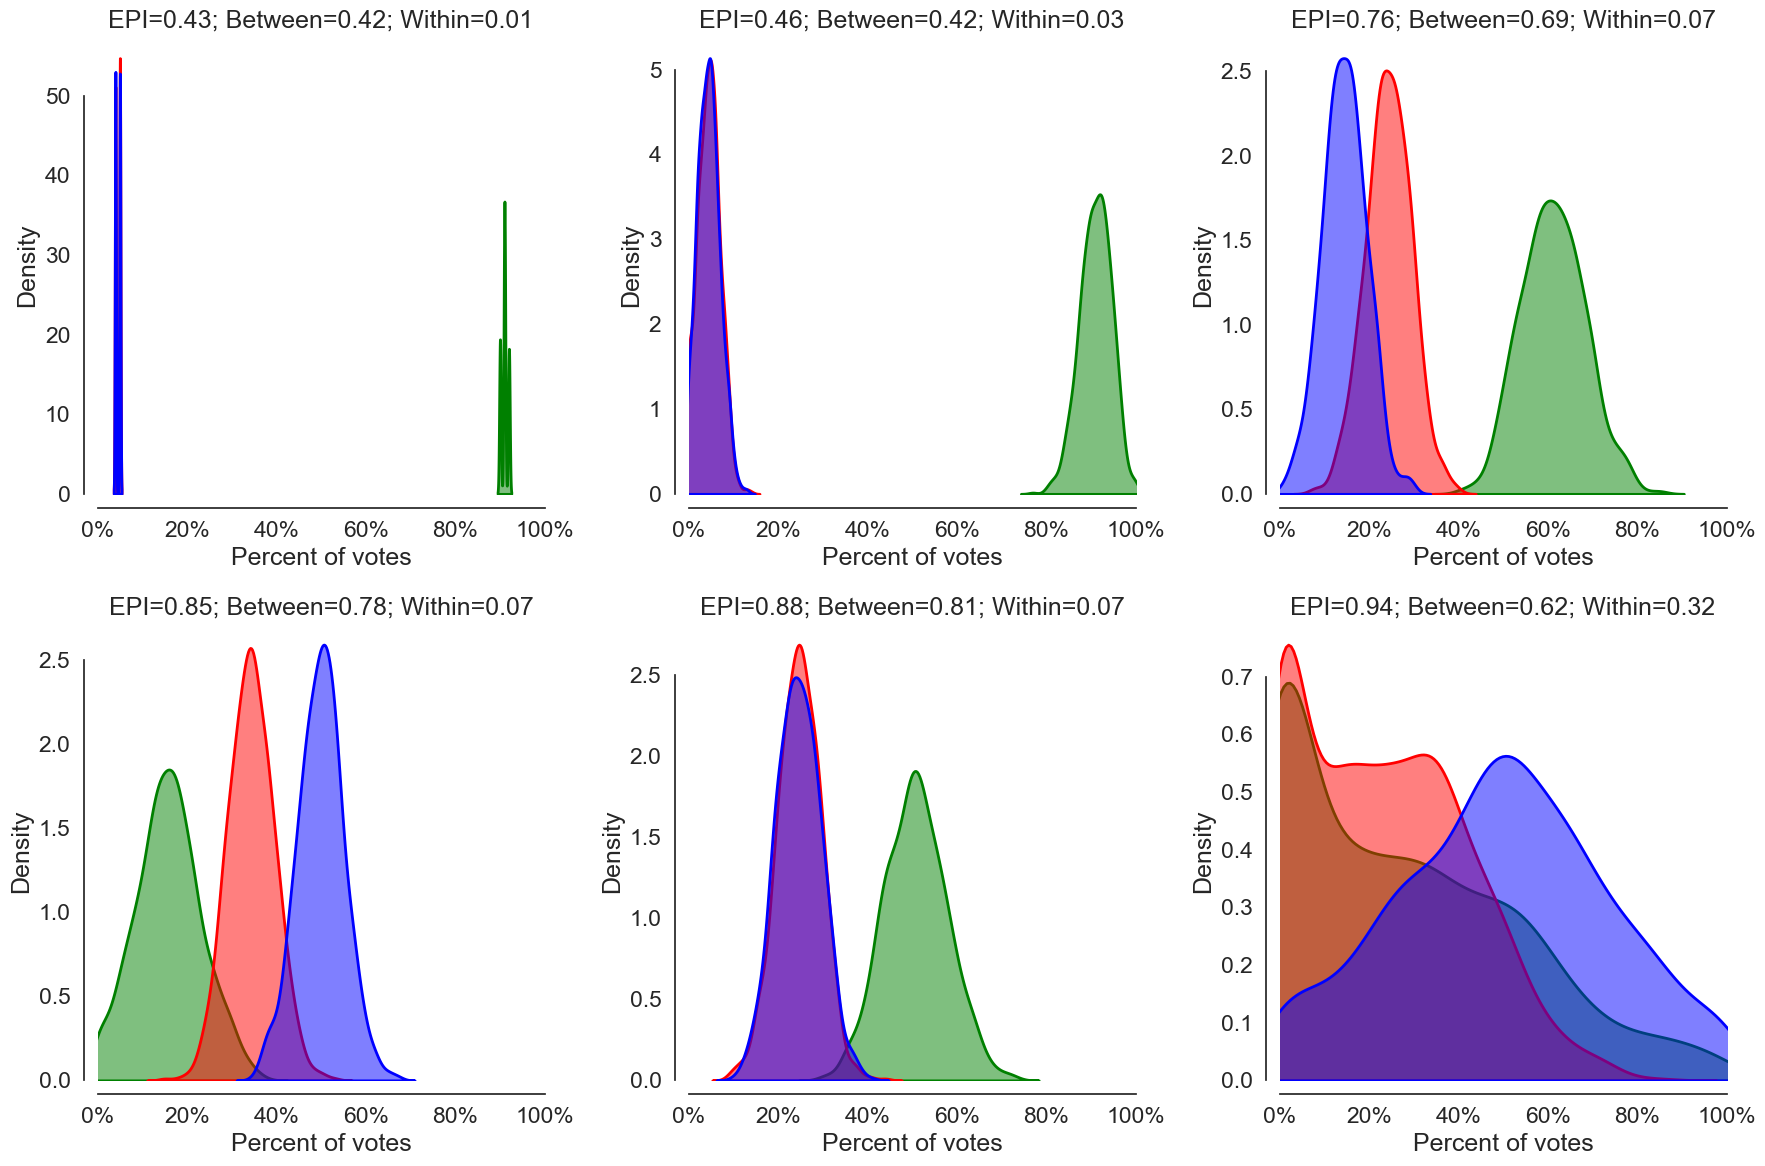

In [25]:
sns.set(font_scale=1.5, style="white")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18, 12))

for i, dd in df.groupby("election_id"):
    ax = axs[int((i - 1)/3), (i - 1)%3]
    sns.kdeplot(x="rate", alpha=.5, legend=False, fill=True, lw=2, hue="candidate", 
                palette=["blue", "red", "green"], data=dd, ax=ax)
    ax.set(xlim=(0, 1))
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.set_xlabel("Percent of votes")
    ax.set_title(f"EPI={round(epi[i]['total'], 2)}; Between={round(epi[i]['between'], 2)}; Within={round(epi[i]['within'], 2)}")

sns.despine(offset=10, trim=True)
fig.tight_layout()


In [26]:
df_election.groupby(["election_id", "N_units", "candidate"]).agg({"rate": "mean"})

rate
election_id N_units candidate          
1-2         2       0          0.582218
                    1          0.417782
            3       0          0.492204
                    1          0.507796
            5       0          0.233583
...                                 ...
99-6        5000    1          0.166054
                    2          0.166328
                    3          0.167245
                    4          0.168752
                    5          0.166685

[30000 rows x 1 columns]

In [27]:
df_winner = df_election.groupby(["election_id", "N_units", "candidate"]).agg({"rate": "mean"})\
    .sort_values(["election_id", "N_units", "rate"], ascending=False).groupby(["election_id", "N_units"]).head(1).reset_index()\
    .rename(columns={"rate": "percent"})
df_winner.head()

,election_id,N_units,candidate,percent
0,99-6,5000,4,0.168752
1,99-6,1000,2,0.174717
2,99-6,100,1,0.187479
3,99-6,5,3,0.215710
4,99-6,3,0,0.268074


In [28]:
df_dispersion = pd.merge(df_election, df_winner, on=["election_id", "candidate"]).groupby("election_id").agg({"rate": "std"}) ** 2
df_dispersion = df_dispersion.reset_index().rename(columns={"rate": "dispersion"})
df_dispersion.head()

,election_id,dispersion
0,1-2,0.083672
1,1-3,0.055782
2,1-4,0.038488
3,1-5,0.026798
4,1-6,0.019679


In [29]:
df_descriptive = pd.merge(df_winner, df_dispersion, on="election_id")
df_descriptive.head()

,election_id,N_units,candidate,percent,dispersion
0,99-6,5000,4,0.168752,0.019877
1,99-6,1000,2,0.174717,0.019877
2,99-6,100,1,0.187479,0.019877
3,99-6,5,3,0.215710,0.019877
4,99-6,3,0,0.268074,0.019877


In [30]:
df_epi = data.groupby(["election_id", "N_candidates", "N_units", "type"]).agg({"value": "sum"}).reset_index()\
    .pivot(index=["election_id", "N_candidates", "N_units"], columns="type", values="value").reset_index()
# df_epi = df_epi[df_epi["N_candidates"] > 2]
df_epi["Between_b"] = pd.cut(df_epi["Between"], 11).apply(lambda x: x.mid)
df_epi["epi"] = df_epi["Between"] + df_epi["Within"]
df_epi["proportion"] = df_epi["Between"] / df_epi["Within"]
# df_epi["proportion"] = df_epi["Within"] / df_epi["Between"]
df_epi["proportion2"] = df_epi["proportion"] / df_epi["N_candidates"]
# df_epi["proportion"] = df_epi["proportion"] / ((df_epi["N_candidates"]))
# df_epi["proportion4"] =  (df_epi["proportion"]) * ((df_epi["N_candidates"] - 1))

# 0.83166275
df_epi.head()

type,election_id,N_candidates,N_units,Between,Within,Between_b,epi,proportion,proportion2
0,1-2,2,2,0.326510,0.692183,0.3580,1.018693,0.471710,0.235855
1,1-2,2,3,0.371812,0.631620,0.3580,1.003433,0.588664,0.294332
2,1-2,2,5,0.434790,0.409016,0.4405,0.843805,1.063014,0.531507
3,1-2,2,100,0.536824,0.464764,0.5230,1.001589,1.155047,0.577523
4,1-2,2,1000,0.499774,0.500174,0.5230,0.999948,0.999201,0.499601


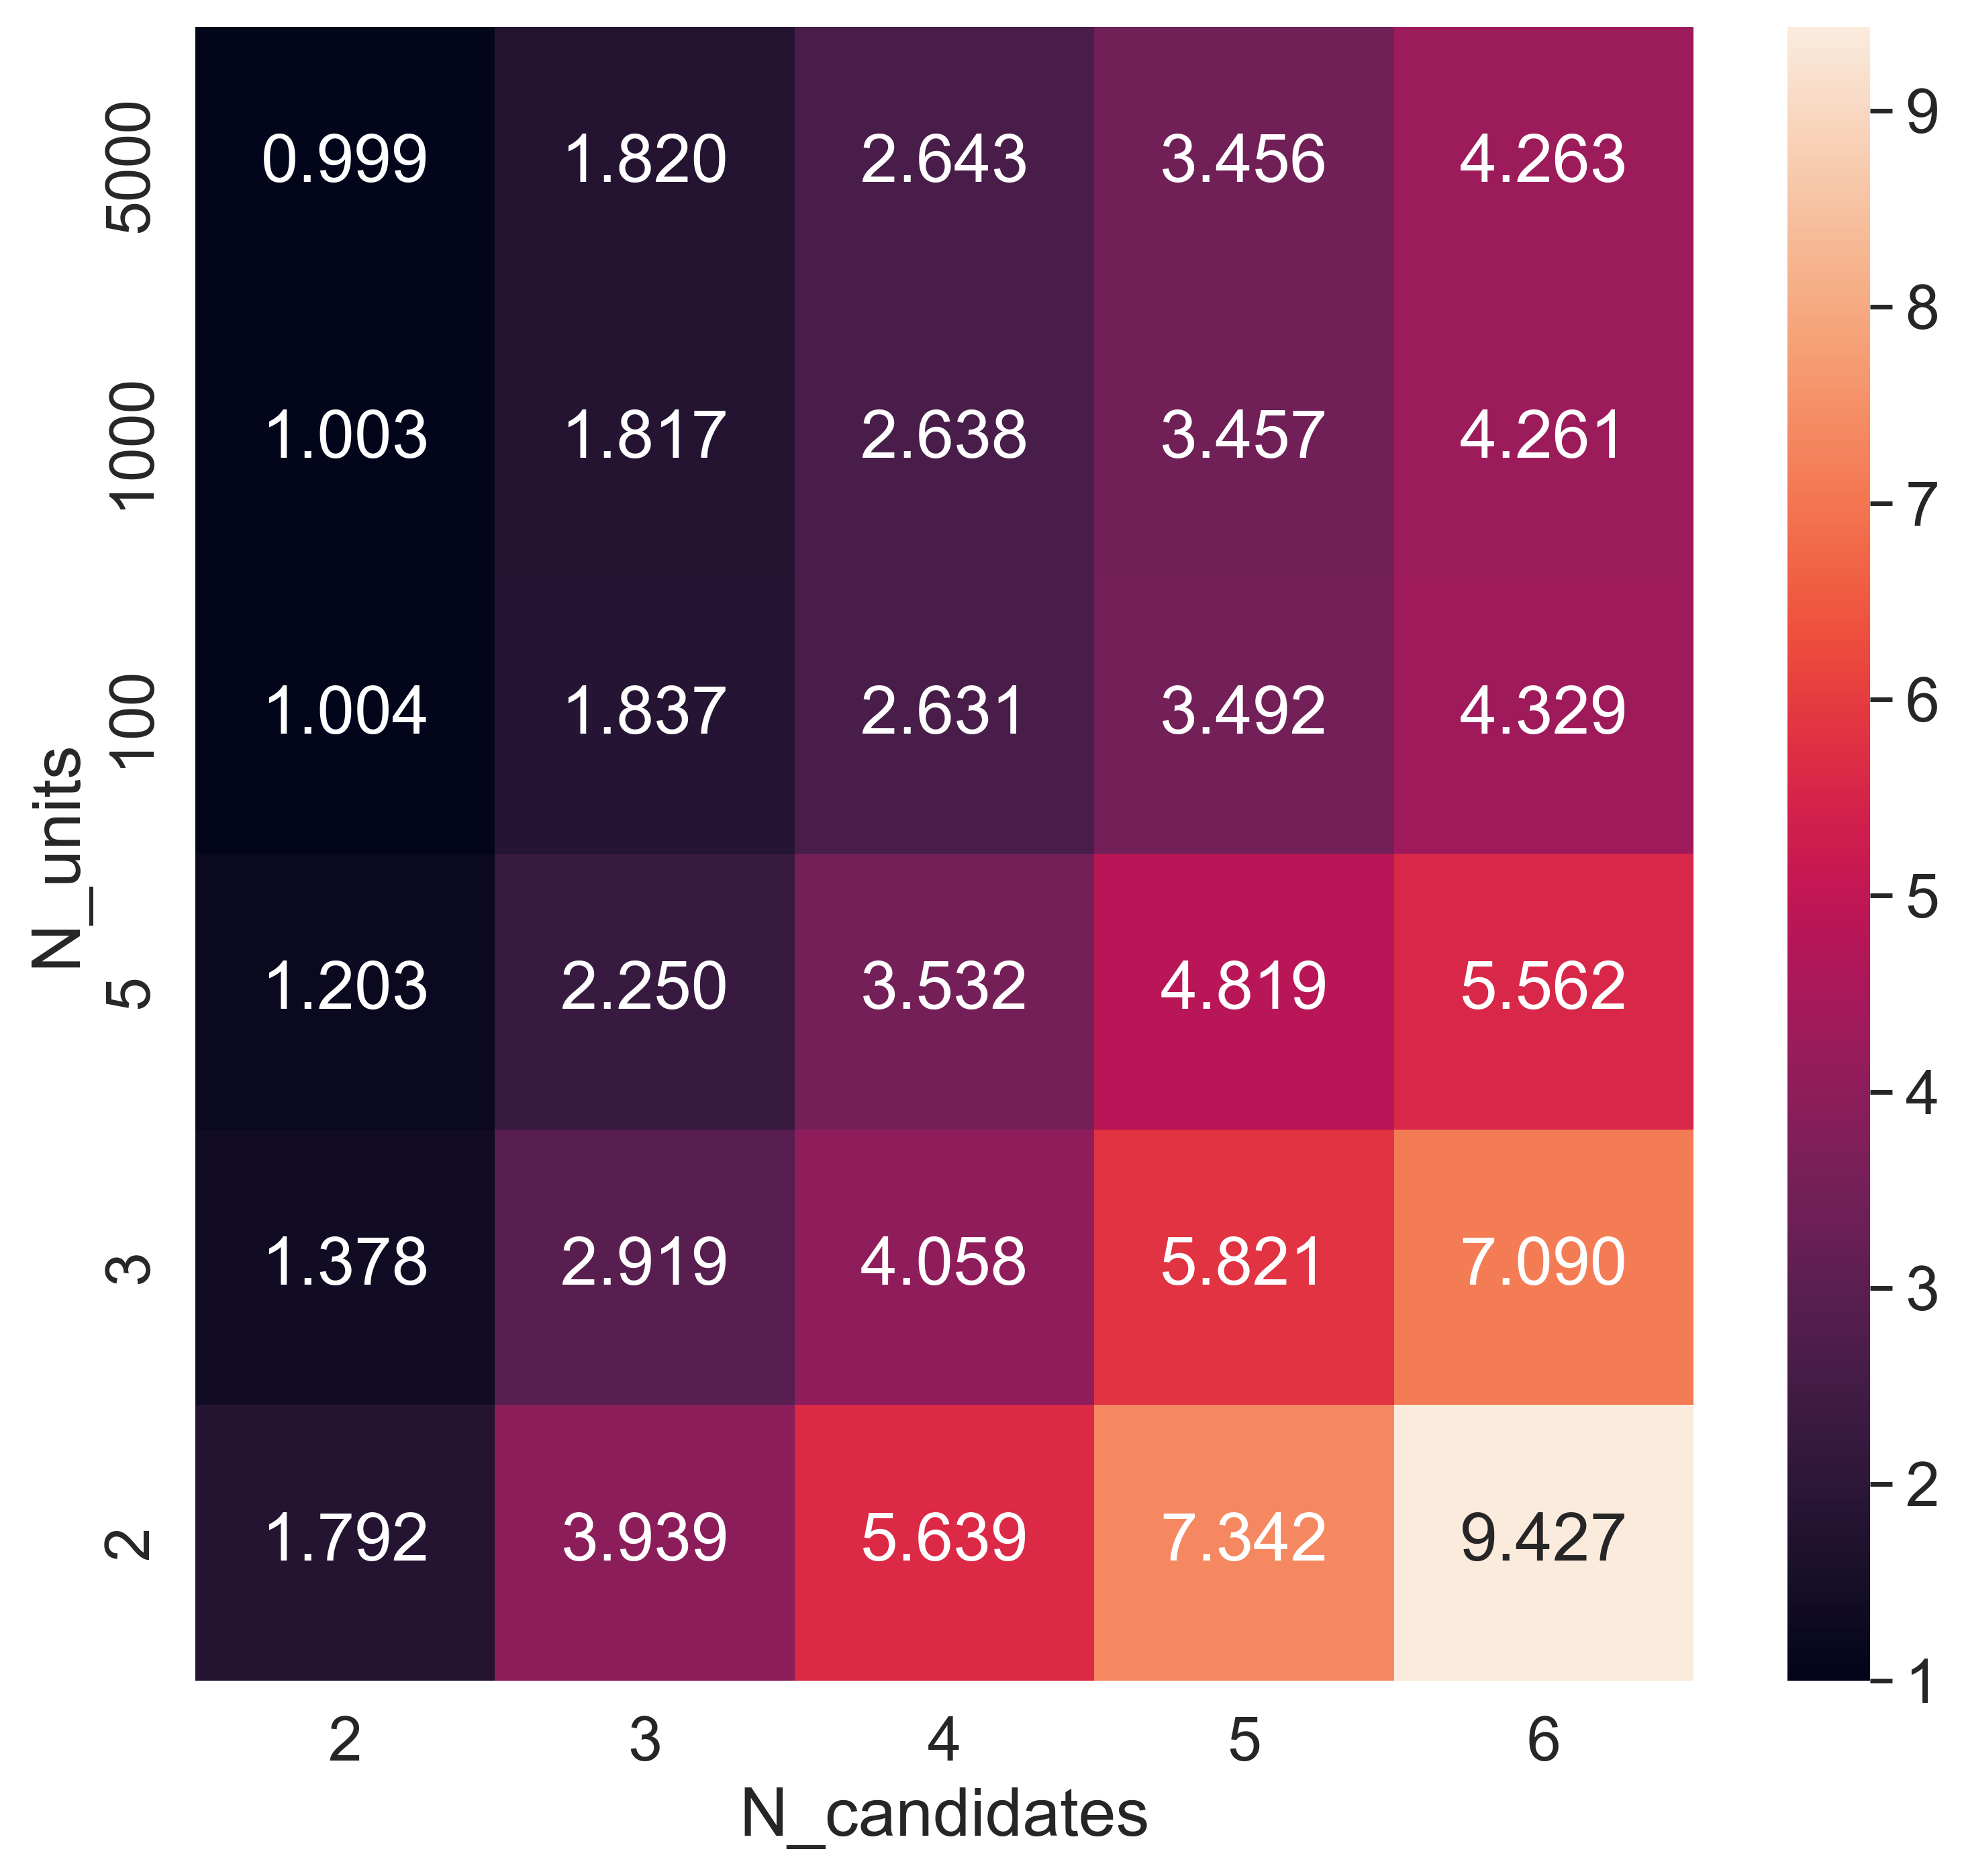

In [31]:
fig, axs = plt.subplots(figsize=(9, 8), dpi=400)


dd = df_epi.groupby(["N_candidates", "N_units"]).agg({"proportion": "median"}).reset_index()
# dd = dd[dd["N_candidates"] > 2]
g = sns.heatmap(dd.pivot(index="N_units", columns="N_candidates", values="proportion"), annot=True, fmt=".3f"
)
g.invert_yaxis()
